# Import the necessary libraries

In [1]:
!pip install opencv-python

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import os
import numpy as np
import torch.nn.init
import glob
import datetime
import tqdm
import yaml
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.model_selection import GridSearchCV


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import os
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /home/admin1/student1/Joel


# Load the config

In [5]:
class Config(dict):
    __getattr__ = dict.__getitem__

In [6]:
# Define the path to your file in Google Drive
file_path = '/home/admin1/student1/Joel/segm_config (2).yaml'

# Open the file
with open(file_path, 'r') as f:
    args_dict = yaml.safe_load(f)

args = Config(args_dict)

print(args)
print(args.input)

{'nChannel': 8, 'nConv': 2, 'epoch': 50, 'maxUpdate': 10, 'batch_size': 64, 'lr': 0.0001, 'minLabels': 8, 'stepsize_sim': 1, 'stepsize_con': 5, 'imsize': [224, 224], 'input': '/home/admin1/student1/Joel/dataset', 'model_safename': 'testmodel', 'model_load_path': '/home/admin1/student1/Joel/dataset/testmodel.pth', 'mode': 'test_dataset'}
/home/admin1/student1/Joel/dataset


# Define the class for the model

In [7]:
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args.nConv-1):
            self.conv2.append( nn.Conv2d(args.nChannel, args.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args.nChannel) )
        self.conv3 = nn.Conv2d(args.nChannel, args.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(args.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(args.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

# Check if Cuda is used

In [8]:
use_cuda = torch.cuda.is_available() # check if GPU is available, if yes use it

if use_cuda:
    print('Using GPU')
else:
    print('Using CPU')

Using CPU


/home/admin1/anaconda3/envs/joel_pt/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# List with all train images

In [9]:
import os
files = os.listdir(args.input + '/train/')

In [10]:
img_list = sorted(glob.glob(args.input+'/train/*')) # list with path to all training images
im = cv2.imread(img_list[0]) # import first image to get shape
print(im.shape)

(480, 640, 3)


In [11]:
# Prepare your validation dataset
val_img_list = sorted(glob.glob(args.input + '/val/*'))
val_im = cv2.imread(img_list[0]) # import first image to get shape
print(val_im.shape)

(480, 640, 3)


# Init model and set to train mode

In [12]:
model = MyNet(im.shape[2]) # im.shape[2] is the number of channels --> 3: RGB, 1: grayscale
if use_cuda:
    model.cuda()
model.train()

MyNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ModuleList(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn2): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# Define the loss functions

In [13]:
# Similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# Continuity loss definition
loss_hpy = torch.nn.L1Loss(reduction='mean')  # Use 'mean' for averaging
loss_hpz = torch.nn.L1Loss(reduction='mean')  # Use 'mean' for averaging

# Define the optimizer

In [14]:
optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=0.9)

# Training the model and save it after each epoch

* adjust learning rate ---> how can this be done?
* delete the old models before training the new models

In [15]:
loss_tracking = [[],[],[],[]]
loss_tracking[0].append("epoch_number")
loss_tracking[1].append("index_number")
loss_tracking[2].append("loop_number")
loss_tracking[3].append("loss")


# Initialize empty lists for loss tracking
training_losses = []
validation_losses = []

# Validation loop
best_val_loss = float('inf')

for epoch in range(args.epoch):
    print(f'Training epoch {epoch + 1} of {args.epoch} started at {datetime.datetime.now()}')

    for im_file in tqdm.tqdm(range(int(len(img_list)/args.batch_size))): # numper of iterations per epoch
        # e.g 100 images and batch_size 10, then 10 iterations

        im = [] # list to store images
        for batch_count in range(args.batch_size):
            # load image
            resized_im = cv2.imread(img_list[args.batch_size*im_file + batch_count])
            resized_im = cv2.resize(resized_im, dsize=(args.imsize[0],args.imsize[1])) # add to config file
            resized_im = resized_im.transpose((2,0,1)).astype('float32')/255.
            im.append(resized_im)

        for loop in range(args.maxUpdate): # number of loops per iteration

            data = torch.from_numpy(np.array(im)) # convert numpy list to tensor
            if use_cuda:
                data = data.cuda()

            # not sure what the code below does
            data = Variable(data)

            HPy_target = torch.zeros(data.shape[0],resized_im.shape[1]-1,resized_im.shape[2],args.nChannel)
            HPz_target = torch.zeros(data.shape[0],resized_im.shape[1],resized_im.shape[2]-1,args.nChannel)
            if use_cuda:
                HPy_target = HPy_target.cuda()
                HPz_target = HPz_target.cuda()

            # forwarding
            optimizer.zero_grad()
            output = model(data)
            output = output.permute(0,2,3,1).contiguous().view(data.shape[0],-1,args.nChannel)

            outputHP = output.reshape((data.shape[0],resized_im.shape[1],resized_im.shape[2],args.nChannel))

            HPy = outputHP[:,1:,:,:] - outputHP[:,0:-1,:,:]
            HPz = outputHP[:,:,1:,:] - outputHP[:,:,0:-1,:]
            lhpy = loss_hpy(HPy,HPy_target)
            lhpz = loss_hpz(HPz,HPz_target)

            output = output.reshape(output.shape[0]*output.shape[1],-1)
            ignore,target = torch.max(output,1)

            loss = args.stepsize_sim*loss_fn(output,target)+args.stepsize_con*(lhpy+lhpz)
            loss.backward()
            loss_tracking[0].append(epoch)
            loss_tracking[1].append(im_file)
            loss_tracking[2].append(loop)
            loss_tracking[3].append(loss.item())
            optimizer.step()

    print("loss", loss.item())

        # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_file in val_img_list:
            val_im = cv2.imread(val_file)
            val_im = cv2.resize(val_im, dsize=(args.imsize[0], args.imsize[1]))
            val_im = val_im.transpose((2, 0, 1)).astype('float32') / 255.
            val_data = torch.from_numpy(np.array([val_im]))
            if use_cuda:
                val_data = val_data.cuda()
            val_data = Variable(val_data)

            val_output = model(val_data)
            val_output = val_output.permute(0, 2, 3, 1).contiguous().view(val_data.shape[0], -1, args.nChannel)

            val_outputHP = val_output.reshape((val_data.shape[0], resized_im.shape[1], resized_im.shape[2], args.nChannel))

            HPy_val = val_outputHP[:, 1:, :, :] - val_outputHP[:, 0:-1, :, :]
            HPz_val = val_outputHP[:, :, 1:, :] - val_outputHP[:, :, 0:-1, :]
            lhpy_val = loss_hpy(HPy_val, HPy_target)
            lhpz_val = loss_hpz(HPz_val, HPz_target)

            val_output = val_output.reshape(val_output.shape[0] * val_output.shape[1], -1)
            ignore, val_target = torch.max(val_output, 1)

            val_loss = args.stepsize_sim * loss_fn(val_output, val_target) + args.stepsize_con * (lhpy_val + lhpz_val)
            total_val_loss += val_loss.item()



    average_val_loss = total_val_loss / len(val_img_list)
    print(f'Validation loss after epoch {epoch + 1}: {average_val_loss}')



    # Append training and validation loss to respective lists
    training_losses.append(loss.item())
    validation_losses.append(average_val_loss)

    # Save the model if it has the best validation loss
    #if average_val_loss < best_val_loss:
        #best_val_loss = average_val_loss
        #torch.save(model.state_dict(), os.path.join(args.input, args.model_safename + '.pth'))

    # Set the model back to training mode
    model.train()

#save model after training --> # change the name of the model, maybe add the name to the config file
torch.save(model.state_dict(),os.path.join(args.input,args.model_safename+'.pth'))

Training epoch 1 of 50 started at 2023-11-23 16:40:48.781389


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.46s/it]
/home/admin1/anaconda3/envs/joel_pt/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 223, 224, 8])) that is different to the input size (torch.Size([1, 223, 224, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/admin1/anaconda3/envs/joel_pt/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 224, 223, 8])) that is different to the input size (torch.Size([1, 224, 223, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


loss 1.7705614566802979
Validation loss after epoch 1: 1.8829929402617158
Training epoch 2 of 50 started at 2023-11-23 16:48:30.731600


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.33s/it]


loss 1.641782283782959
Validation loss after epoch 2: 1.697002580322203
Training epoch 3 of 50 started at 2023-11-23 16:56:10.720849


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.42s/it]


loss 1.5574501752853394
Validation loss after epoch 3: 1.576013674892363
Training epoch 4 of 50 started at 2023-11-23 17:03:52.323316


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.36s/it]


loss 1.4798221588134766
Validation loss after epoch 4: 1.466236687097393
Training epoch 5 of 50 started at 2023-11-23 17:11:32.792213


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.33s/it]


loss 1.405470371246338
Validation loss after epoch 5: 1.3752521032192668
Training epoch 6 of 50 started at 2023-11-23 17:19:12.581184


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.33s/it]


loss 1.3362462520599365
Validation loss after epoch 6: 1.3037385647414161
Training epoch 7 of 50 started at 2023-11-23 17:26:52.516665


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.36s/it]


loss 1.2828640937805176
Validation loss after epoch 7: 1.2495852841705573
Training epoch 8 of 50 started at 2023-11-23 17:34:32.846211


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.30s/it]


loss 1.238231897354126
Validation loss after epoch 8: 1.2031700058061567
Training epoch 9 of 50 started at 2023-11-23 17:42:12.160072


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.31s/it]


loss 1.2003819942474365
Validation loss after epoch 9: 1.1633600948286837
Training epoch 10 of 50 started at 2023-11-23 17:49:51.544771


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.31s/it]


loss 1.1674919128417969
Validation loss after epoch 10: 1.1286267710513755
Training epoch 11 of 50 started at 2023-11-23 17:57:31.011256


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.34s/it]


loss 1.1383178234100342
Validation loss after epoch 11: 1.0978137134528552
Training epoch 12 of 50 started at 2023-11-23 18:05:10.917920


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.33s/it]


loss 1.1118872165679932
Validation loss after epoch 12: 1.0700973965105463
Training epoch 13 of 50 started at 2023-11-23 18:12:50.575986


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.31s/it]


loss 1.0875189304351807
Validation loss after epoch 13: 1.044863509056998
Training epoch 14 of 50 started at 2023-11-23 18:20:30.188999


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.31s/it]


loss 1.0648033618927002
Validation loss after epoch 14: 1.0216674318079089
Training epoch 15 of 50 started at 2023-11-23 18:28:09.606144


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.30s/it]


loss 1.0435686111450195
Validation loss after epoch 15: 1.0003819666925025
Training epoch 16 of 50 started at 2023-11-23 18:35:48.850458


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.31s/it]


loss 1.023597002029419
Validation loss after epoch 16: 0.9809100802804603
Training epoch 17 of 50 started at 2023-11-23 18:43:28.241387


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 1.0048648118972778
Validation loss after epoch 17: 0.9634829278852118
Training epoch 18 of 50 started at 2023-11-23 18:51:07.785997


100%|███████████████████████████████████████████| 19/19 [07:03<00:00, 22.30s/it]


loss 0.9877816438674927
Validation loss after epoch 18: 0.9477819383144379
Training epoch 19 of 50 started at 2023-11-23 18:58:47.016295


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 0.9716542363166809
Validation loss after epoch 19: 0.932847065417493
Training epoch 20 of 50 started at 2023-11-23 19:06:26.627782


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 0.9569253325462341
Validation loss after epoch 20: 0.9194595553835885
Training epoch 21 of 50 started at 2023-11-23 19:14:06.234832


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.33s/it]


loss 0.9430736303329468
Validation loss after epoch 21: 0.9071629224253482
Training epoch 22 of 50 started at 2023-11-23 19:21:46.135072


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 0.9300087690353394
Validation loss after epoch 22: 0.8958410828817086
Training epoch 23 of 50 started at 2023-11-23 19:29:25.814118


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.33s/it]


loss 0.917657732963562
Validation loss after epoch 23: 0.885291600227356
Training epoch 24 of 50 started at 2023-11-23 19:37:05.670470


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 0.9059634208679199
Validation loss after epoch 24: 0.8754672714921294
Training epoch 25 of 50 started at 2023-11-23 19:44:45.188955


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.34s/it]


loss 0.8947954177856445
Validation loss after epoch 25: 0.8662561474276371
Training epoch 26 of 50 started at 2023-11-23 19:52:25.188055


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 0.8841392397880554
Validation loss after epoch 26: 0.8575896707714581
Training epoch 27 of 50 started at 2023-11-23 20:00:05.089673


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.32s/it]


loss 0.8738701343536377
Validation loss after epoch 27: 0.8493742479652655
Training epoch 28 of 50 started at 2023-11-23 20:07:44.637943


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.34s/it]


loss 0.8640000820159912
Validation loss after epoch 28: 0.8416654270203388
Training epoch 29 of 50 started at 2023-11-23 20:15:24.710058


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.34s/it]


loss 0.8543474674224854
Validation loss after epoch 29: 0.834324702767075
Training epoch 30 of 50 started at 2023-11-23 20:23:04.758438


100%|███████████████████████████████████████████| 19/19 [07:04<00:00, 22.35s/it]


loss 0.8449907302856445
Validation loss after epoch 30: 0.8274526326382746
Training epoch 31 of 50 started at 2023-11-23 20:30:44.811985


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.37s/it]


loss 0.8356976509094238
Validation loss after epoch 31: 0.820612272962195
Training epoch 32 of 50 started at 2023-11-23 20:38:25.299324


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.37s/it]


loss 0.8264480829238892
Validation loss after epoch 32: 0.8138806551206307
Training epoch 33 of 50 started at 2023-11-23 20:46:06.139988


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.39s/it]


loss 0.8172814249992371
Validation loss after epoch 33: 0.807187180440934
Training epoch 34 of 50 started at 2023-11-23 20:53:47.022241


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.38s/it]


loss 0.8081743717193604
Validation loss after epoch 34: 0.80039722606784
Training epoch 35 of 50 started at 2023-11-23 21:01:28.093362


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.37s/it]


loss 0.7991108894348145
Validation loss after epoch 35: 0.793451337736161
Training epoch 36 of 50 started at 2023-11-23 21:09:08.612193


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.38s/it]


loss 0.7903209924697876
Validation loss after epoch 36: 0.7866180710128097
Training epoch 37 of 50 started at 2023-11-23 21:16:49.332215


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.39s/it]


loss 0.7815856337547302
Validation loss after epoch 37: 0.7797225566183934
Training epoch 38 of 50 started at 2023-11-23 21:24:30.466620


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.40s/it]


loss 0.7729692459106445
Validation loss after epoch 38: 0.7728352358106707
Training epoch 39 of 50 started at 2023-11-23 21:32:11.561167


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.43s/it]


loss 0.7637073993682861
Validation loss after epoch 39: 0.765009963023858
Training epoch 40 of 50 started at 2023-11-23 21:39:53.191346


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.43s/it]


loss 0.7540671825408936
Validation loss after epoch 40: 0.7566530512004602
Training epoch 41 of 50 started at 2023-11-23 21:47:34.930448


100%|███████████████████████████████████████████| 19/19 [07:05<00:00, 22.42s/it]


loss 0.7456033229827881
Validation loss after epoch 41: 0.7495556950569153
Training epoch 42 of 50 started at 2023-11-23 21:55:16.447159


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.44s/it]


loss 0.7370635271072388
Validation loss after epoch 42: 0.7421350553387501
Training epoch 43 of 50 started at 2023-11-23 22:02:58.274080


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.45s/it]


loss 0.729084849357605
Validation loss after epoch 43: 0.735185694499094
Training epoch 44 of 50 started at 2023-11-23 22:10:40.391150


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.45s/it]


loss 0.7211624383926392
Validation loss after epoch 44: 0.7282306575384296
Training epoch 45 of 50 started at 2023-11-23 22:18:22.705835


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.46s/it]


loss 0.7129763960838318
Validation loss after epoch 45: 0.7211231481833537
Training epoch 46 of 50 started at 2023-11-23 22:26:05.129525


100%|███████████████████████████████████████████| 19/19 [07:07<00:00, 22.48s/it]


loss 0.7037408351898193
Validation loss after epoch 46: 0.7131308430042423
Training epoch 47 of 50 started at 2023-11-23 22:33:47.922671


100%|███████████████████████████████████████████| 19/19 [07:07<00:00, 22.48s/it]


loss 0.6949008703231812
Validation loss after epoch 47: 0.70562964150163
Training epoch 48 of 50 started at 2023-11-23 22:41:30.662654


100%|███████████████████████████████████████████| 19/19 [07:06<00:00, 22.47s/it]


loss 0.6864389777183533
Validation loss after epoch 48: 0.6981648402624443
Training epoch 49 of 50 started at 2023-11-23 22:49:13.392067


100%|███████████████████████████████████████████| 19/19 [07:07<00:00, 22.48s/it]


loss 0.6776639223098755
Validation loss after epoch 49: 0.6901867418015589
Training epoch 50 of 50 started at 2023-11-23 22:56:56.045189


100%|███████████████████████████████████████████| 19/19 [07:07<00:00, 22.49s/it]


loss 0.6680334806442261
Validation loss after epoch 50: 0.6817011634834477


In [16]:
'''import matplotlib.pyplot as plt

# Extract the loss values from the loss_tracking list
epochs = loss_tracking[0][1:]  # Exclude the header
batches = loss_tracking[1][1:]
loops = loss_tracking[2][1:]
loss_values = loss_tracking[3][1:]

# Create a scatter plot of loss values
plt.scatter(range(len(loss_values)), loss_values, s=5, c='blue', alpha=0.5)
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Loss Function During Training')

# Optionally, you can customize the x-axis labels based on epochs, batches, and loops
# For example:
# x_ticks = [f'Epoch {e}, Batch {b}, Loop {l}' for e, b, l in zip(epochs, batches, loops)]
# plt.xticks(range(len(loss_values)), x_ticks, rotation=45)

plt.show()
'''

"import matplotlib.pyplot as plt\n\n# Extract the loss values from the loss_tracking list\nepochs = loss_tracking[0][1:]  # Exclude the header\nbatches = loss_tracking[1][1:]\nloops = loss_tracking[2][1:]\nloss_values = loss_tracking[3][1:]\n\n# Create a scatter plot of loss values\nplt.scatter(range(len(loss_values)), loss_values, s=5, c='blue', alpha=0.5)\nplt.xlabel('Training Iterations')\nplt.ylabel('Loss')\nplt.title('Loss Function During Training')\n\n# Optionally, you can customize the x-axis labels based on epochs, batches, and loops\n# For example:\n# x_ticks = [f'Epoch {e}, Batch {b}, Loop {l}' for e, b, l in zip(epochs, batches, loops)]\n# plt.xticks(range(len(loss_values)), x_ticks, rotation=45)\n\nplt.show()\n"

In [17]:
'''
import matplotlib.pyplot as plt

# Assuming you have collected the loss values for each iteration in loss_tracking
loss_values = loss_tracking[3][1:]  # Exclude the header row

# Convert the loss values to floats
loss_values = [float(loss) for loss in loss_values]
num_iterations_per_epoch=534
# Assuming you know the number of iterations per epoch (e.g., num_iterations_per_epoch)
num_epochs = len(loss_values) // num_iterations_per_epoch

# Calculate the average loss for each epoch
epoch_losses = []
for epoch in range(num_epochs):
    start_idx = epoch * num_iterations_per_epoch
    end_idx = start_idx + num_iterations_per_epoch
    epoch_loss = sum(loss_values[start_idx:end_idx]) / num_iterations_per_epoch
    epoch_losses.append(epoch_loss)

# Generate the x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot the training loss vs. epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Assuming you have collected the loss values for each iteration in loss_tracking\nloss_values = loss_tracking[3][1:]  # Exclude the header row\n\n# Convert the loss values to floats\nloss_values = [float(loss) for loss in loss_values]\nnum_iterations_per_epoch=534\n# Assuming you know the number of iterations per epoch (e.g., num_iterations_per_epoch)\nnum_epochs = len(loss_values) // num_iterations_per_epoch\n\n# Calculate the average loss for each epoch\nepoch_losses = []\nfor epoch in range(num_epochs):\n    start_idx = epoch * num_iterations_per_epoch\n    end_idx = start_idx + num_iterations_per_epoch\n    epoch_loss = sum(loss_values[start_idx:end_idx]) / num_iterations_per_epoch\n    epoch_losses.append(epoch_loss)\n\n# Generate the x-axis values (epochs)\nepochs = range(1, num_epochs + 1)\n\n# Plot the training loss vs. epoch\nplt.figure(figsize=(10, 6))\nplt.plot(epochs, epoch_losses, marker='o', linestyle='-', color='b')\nplt.xlabel('Epo

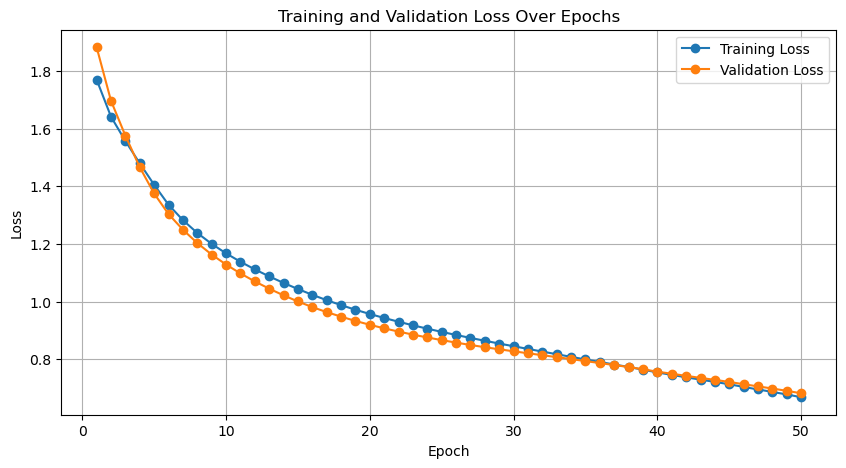

In [18]:
import matplotlib.pyplot as plt

# Create a plot of epoch vs. training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, args.epoch + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, args.epoch + 1), validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()